In [ ]:
!pip install timm
!pip install wandb
!pip install torchinfo
!pip install --upgrade matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
## Permisos para acceder a la ubicación
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import nibabel as nib
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
import  sklearn.metrics
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import wandb
from torch.optim.lr_scheduler import CosineAnnealingLR


# Definir el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Ruta del conjunto de datos
output_dir='/content/drive/MyDrive/SartajDataset'

# Crear directorio de salida si no existe
os.makedirs(output_dir, exist_ok=True)

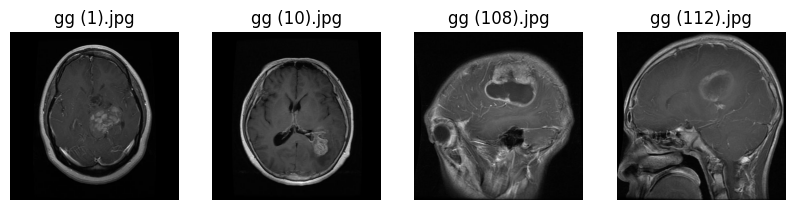

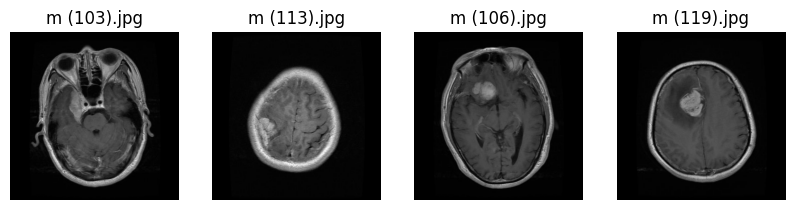

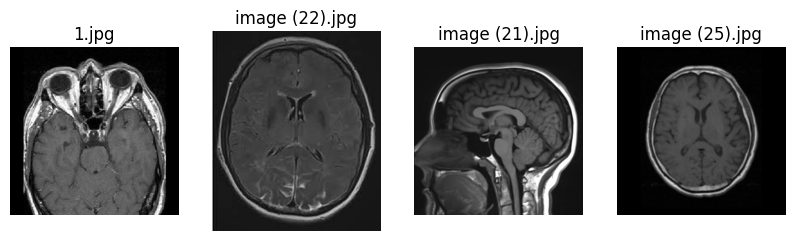

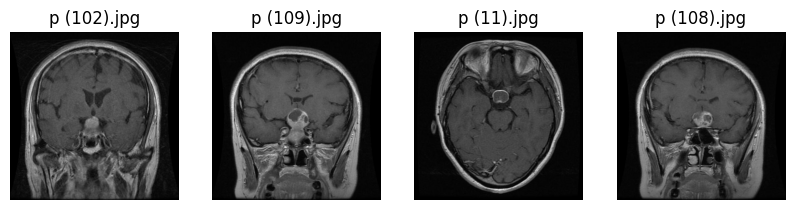

In [ ]:
def visualize_images(class_name, num_images=4):
    class_path = os.path.join(output_dir, class_name)
    images = [img for img in os.listdir(class_path) if img.endswith('.jpg')]

    plt.figure(figsize=(10, 5))
    for i in range(min(num_images, len(images))):
        img_path = os.path.join(class_path, images[i])
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(images[i])

    plt.show()

# Visualizar algunas imágenes de HGG y LGG
visualize_images('/content/drive/MyDrive/SartajDataset/Training/glioma_tumor', num_images=4)
visualize_images('/content/drive/MyDrive/SartajDataset/Training/meningioma_tumor', num_images=4)
visualize_images('/content/drive/MyDrive/SartajDataset/Training/no_tumor', num_images=4)
visualize_images('/content/drive/MyDrive/SartajDataset/Training/pituitary_tumor', num_images=4)

In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, glioma_dir, meningioma_dir, no_tumor_dir, pituitary_dir, transform=None):
        """
        Inicializa el dataset.

        :param glioma_dir: Directorio de imágenes de la clase glioma_tumor.
        :param meningioma_dir: Directorio de imágenes de la clase meningioma_tumor.
        :param no_tumor_dir: Directorio de imágenes de la clase no_tumor.
        :param pituitary_dir: Directorio de imágenes de la clase pituitary_tumor.
        :param transform: Transformaciones a aplicar a las imágenes.
        """
        self.glioma_dir = glioma_dir
        self.meningioma_dir = meningioma_dir
        self.no_tumor_dir = no_tumor_dir
        self.pituitary_dir = pituitary_dir
        self.transform = transform

        # Listas para almacenar las rutas de las imágenes y las etiquetas correspondientes
        self.images = []
        self.labels = []

        # Cargar imágenes y etiquetas
        self._load_images()

    def _load_images(self):
        """
        Carga las imágenes de los directorios y asigna etiquetas.
        """
        # Cargar imágenes de glioma_tumor (etiqueta 0)
        for img_name in os.listdir(self.glioma_dir):
            img_path = os.path.join(self.glioma_dir, img_name)
            self.images.append(img_path)
            self.labels.append(0)  # Etiqueta 0 para glioma_tumor

        # Cargar imágenes de meningioma_tumor (etiqueta 1)
        for img_name in os.listdir(self.meningioma_dir):
            img_path = os.path.join(self.meningioma_dir, img_name)
            self.images.append(img_path)
            self.labels.append(1)  # Etiqueta 1 para meningioma_tumor

        # Cargar imágenes de no_tumor (etiqueta 2)
        for img_name in os.listdir(self.no_tumor_dir):
            img_path = os.path.join(self.no_tumor_dir, img_name)
            self.images.append(img_path)
            self.labels.append(2)  # Etiqueta 2 para no_tumor

        # Cargar imágenes de pituitary_tumor (etiqueta 3)
        for img_name in os.listdir(self.pituitary_dir):
            img_path = os.path.join(self.pituitary_dir, img_name)
            self.images.append(img_path)
            self.labels.append(3)  # Etiqueta 3 para pituitary_tumor

    def __len__(self):
        """
        Devuelve el número total de imágenes en el dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Devuelve una imagen y su etiqueta correspondiente.

        :param idx: Índice de la imagen que se desea obtener.
        :return: Tupla (imagen, etiqueta).
        """
        # Obtener la ruta de la imagen y cargarla
        img_path = self.images[idx]
        img = Image.open(img_path).convert("RGB")  # Asegurarse de que la imagen sea RGB

        # Obtener la etiqueta correspondiente
        label = self.labels[idx]

        # Aplicar la transformación si está definida
        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image

class CustomTestDataset(Dataset):
    def __init__(self, glioma_test_dir, meningioma_test_dir, no_tumor_test_dir, pituitary_test_dir, transform=None):
        """
        Inicializa el dataset de prueba con el 100% de las imágenes de cada clase.

        :param glioma_test_dir: Directorio de imágenes de la clase glioma_tumor para prueba.
        :param meningioma_test_dir: Directorio de imágenes de la clase meningioma_tumor para prueba.
        :param no_tumor_test_dir: Directorio de imágenes de la clase no_tumor para prueba.
        :param pituitary_test_dir: Directorio de imágenes de la clase pituitary_tumor para prueba.
        :param transform: Transformaciones a aplicar a las imágenes.
        """
        self.glioma_test_dir = glioma_test_dir
        self.meningioma_test_dir = meningioma_test_dir
        self.no_tumor_test_dir = no_tumor_test_dir
        self.pituitary_test_dir = pituitary_test_dir
        self.transform = transform

        # Listas para almacenar las rutas de las imágenes y las etiquetas correspondientes
        self.images = []
        self.labels = []

        # Cargar el 100% de las imágenes de cada clase
        self._load_images()

    def _load_images(self):
        """
        Carga el 100% de las imágenes de cada directorio y asigna etiquetas.
        """
        def load_images_from_dir(directory, label):
            all_images = os.listdir(directory)
            for img_name in all_images:
                img_path = os.path.join(directory, img_name)
                self.images.append(img_path)
                self.labels.append(label)

        # Cargar imágenes de cada clase con su etiqueta correspondiente
        load_images_from_dir(self.glioma_test_dir, 0)      # Glioma tumor
        load_images_from_dir(self.meningioma_test_dir, 1)  # Meningioma tumor
        load_images_from_dir(self.no_tumor_test_dir, 2)    # No tumor
        load_images_from_dir(self.pituitary_test_dir, 3)   # Pituitary tumor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]



In [ ]:
##Verificar numero de imagenes en training folder
glioma_tumor_dir = '/content/drive/MyDrive/SartajDataset/Training/glioma_tumor'
meningioma_tumor_dir = '/content/drive/MyDrive/SartajDataset/Training/meningioma_tumor'
no_tumor_dir= '/content/drive/MyDrive/SartajDataset/Training/no_tumor'
pituitary_tumor_dir= '/content/drive/MyDrive/SartajDataset/Training/pituitary_tumor'

# Contar imágenes en glioma
glioma_images = os.listdir(glioma_tumor_dir)
glioma_count = len(glioma_images)

# Contar imágenes en glioma
meningioma_images = os.listdir(meningioma_tumor_dir)
meningioma_count = len(meningioma_images)

# Contar imágenes en glioma
no_tumor_images = os.listdir(no_tumor_dir)
no_tumor_count = len(no_tumor_images)

# Contar imágenes en glioma
pituitary_images = os.listdir(pituitary_tumor_dir)
pituitary_count = len(pituitary_images)


# Imprimir resultados
print(f'Número de imágenes en Glioma file: {glioma_count}')
print(f'Número de imágenes en Meningioma file: {meningioma_count}')
print(f'Número de imágenes en No_tumor file: {no_tumor_count}')
print(f'Número de imágenes en Pituitary file: {pituitary_count}')


Número de imágenes en Glioma file: 826
Número de imágenes en Meningioma file: 822
Número de imágenes en No_tumor file: 395
Número de imágenes en Pituitary file: 827


In [ ]:
# Definir transformaciones para el conjunto de training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ajusta el tamaño
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Cambiar brillo, contraste, etc.
    transforms.RandomRotation(45),  # Rotación aleatoria
    transforms.RandomHorizontalFlip(),    #Se voltea la imagen horizontalmente
    transforms.RandomVerticalFlip(),   #Se voltea verticalmente
   # transforms.RandomPerspective(),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

#Definir transformaciones para el conjunto de testing
# Transformaciones para el conjunto de prueba
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

In [ ]:
# Cargar el conjunto de datos completo
train_dataset = CustomDataset(glioma_tumor_dir, meningioma_tumor_dir, no_tumor_dir, pituitary_tumor_dir,  transform=train_transform)

In [ ]:
import os

# Verificar número de imágenes en testing folder
glioma_tumor_test_dir = '/content/drive/MyDrive/SartajDataset/Testing/glioma_tumor'
meningioma_tumor_test_dir = '/content/drive/MyDrive/SartajDataset/Testing/meningioma_tumor'
no_tumor_test_dir = '/content/drive/MyDrive/SartajDataset/Testing/no_tumor'
pituitary_tumor_test_dir = '/content/drive/MyDrive/SartajDataset/Testing/pituitary_tumor'

# Contar imágenes en glioma
glioma_images = os.listdir(glioma_tumor_test_dir)
glioma_count = len(glioma_images)

# Contar imágenes en meningioma
meningioma_images = os.listdir(meningioma_tumor_test_dir)
meningioma_count = len(meningioma_images)

# Contar imágenes en no_tumor
no_tumor_images = os.listdir(no_tumor_test_dir)
no_tumor_count = len(no_tumor_images)

# Contar imágenes en pituitary
pituitary_images = os.listdir(pituitary_tumor_test_dir)
pituitary_count = len(pituitary_images)

# Imprimir resultados
print(f'Número de imágenes en Glioma file (Testing): {glioma_count}')
print(f'Número de imágenes en Meningioma file (Testing): {meningioma_count}')
print(f'Número de imágenes en No_tumor file (Testing): {no_tumor_count}')
print(f'Número de imágenes en Pituitary file (Testing): {pituitary_count}')


Número de imágenes en Glioma file (Testing): 100
Número de imágenes en Meningioma file (Testing): 115
Número de imágenes en No_tumor file (Testing): 105
Número de imágenes en Pituitary file (Testing): 74


In [ ]:
##Cargar el conjunto de prueba
test_dataset = CustomTestDataset(glioma_tumor_test_dir, meningioma_tumor_test_dir, no_tumor_test_dir, pituitary_tumor_test_dir, transform=test_transform)


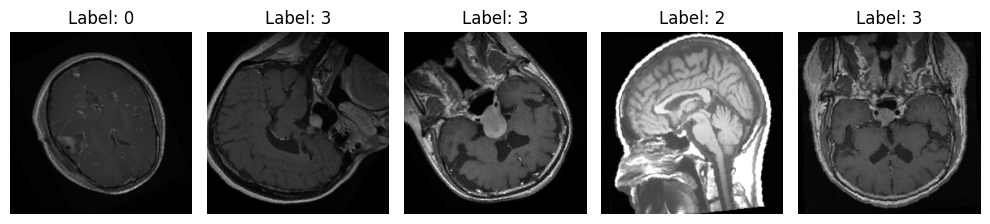

In [ ]:
# Número de imágenes a mostrar
num_images_to_show = 5

# Crear la figura con subgráficos en una fila
fig, axes = plt.subplots(1, num_images_to_show, figsize=(10, 10))

# Mostrar algunas imágenes transformadas
for i in range(num_images_to_show):
    # Seleccionar una imagen aleatoria y su etiqueta
    idx = torch.randint(0, len(train_dataset), (1,)).item()  # Generar un índice aleatorio
    image, label = train_dataset[idx]  # Obtener la imagen y la etiqueta

    # Convertir la imagen de tensor (C, H, W) a (H, W, C) para la visualización
    image = image.permute(1, 2, 0).numpy()  # Convertir a formato (H, W, C)

    # Mostrar la imagen en el subplot correspondiente
    ax = axes[i]  # Obtener el eje para esta imagen
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')  # Desactivar los ejes

# Ajustar el layout para que no se solapen las imágenes
plt.tight_layout()
plt.show()

In [ ]:
import torch
from torch.utils.data import random_split

# Porcentaje configurable (por ejemplo: 10%)
subset_percentage = 0.1  # 10%

# Número mínimo de muestras para el conjunto de prueba (opcional)
min_test_samples = 20

# Calcular número de muestras para el subconjunto de entrenamiento
num_train_samples = int(len(train_dataset) * subset_percentage)

# Calcular número de muestras para el subconjunto de prueba (con mínimo)
num_test_samples = max(int(len(test_dataset) * subset_percentage), min_test_samples)

# Dividir aleatoriamente el dataset de entrenamiento
train_subset, _ = random_split(train_dataset, [num_train_samples, len(train_dataset) - num_train_samples])

# Dividir aleatoriamente el dataset de prueba
test_subset, _ = random_split(test_dataset, [num_test_samples, len(test_dataset) - num_test_samples])

# Verificar los tamaños de los subconjuntos
print(f"Tamaño del subconjunto de entrenamiento (train_subset): {len(train_subset)}")
print(f"Tamaño del subconjunto de prueba (test_subset): {len(test_subset)}")



Tamaño del subconjunto de entrenamiento (train_subset): 287
Tamaño del subconjunto de prueba (test_subset): 39


In [ ]:
# Crear los DataLoaders
train_loader = DataLoader(train_subset, batch_size= 32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Verificar el tamaño de los DataLoaders
print(f'Tamaño de los batches en el DataLoader de entrenamiento: {len(train_loader)}')
print(f'Tamaño de los batches en el DataLoader de prueba: {len(test_loader)}')


Tamaño de los batches en el DataLoader de entrenamiento: 9
Tamaño de los batches en el DataLoader de prueba: 2


In [ ]:
for images, labels in train_loader:
    print("Imagenes Shape:", images.shape)  # Debería ser [batch_size, channels, height, width]
    print("Etiquetas Shape:", labels.shape)  # Debería ser [batch_size] para clasificación

    images, labels = images.to(device), labels.to(device)  # Mover a GPU si es necesario
    break  # Salir

Imagenes Shape: torch.Size([32, 3, 224, 224])
Etiquetas Shape: torch.Size([32])


In [ ]:
# Comprobar si hay una GPU disponible y usarla
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definir el modelo

model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=4)

model = model.to(device)   ### inicializa con pesos preentrenados en ImageNet+

# Definir el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Ajusta la tasa de aprendizaje aquí  lr=1e-4

# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()
  # Para clasificación binaria

# Imprimir la configuración
print(f"Función de pérdida: {criterion}")
print(f"Optimizador: {optimizer}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Función de pérdida: CrossEntropyLoss()
Optimizador: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [ ]:
# Pasamos las imágenes al modelo
outputs = model(images)

# Verificamos las dimensiones de las salidas
print("Salidas Shape:", outputs.shape)  # Debería ser [batch_size, num_classes]

# Verificamos que las salidas no sean NaN ni Inf
if torch.isnan(outputs).any() or torch.isinf(outputs).any():
    print("¡Hay NaNs o Inf en las salidas!")
else:
    print("Las salidas son válidas.")

# Si estamos usando CrossEntropyLoss, los outputs deberían ser logits (sin pasar por softmax aún)


Salidas Shape: torch.Size([32, 4])
Las salidas son válidas.


In [ ]:
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Función para obtener las activaciones de las capas usando hooks
def register_hooks(model):
    activations = {}

    def save_activation(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook

    # Buscar la última capa convolucional del modelo
    last_conv_layer = None
    for name, layer in model.named_modules():
        if isinstance(layer, torch.nn.Conv2d):
            last_conv_layer = layer  # Guarda la última capa convolucional

    if last_conv_layer is None:
        raise ValueError("No se encontró una capa convolucional en el modelo.")

    # Registrar el hook en la salida de la capa convolucional
    last_conv_layer.register_forward_hook(save_activation('last_conv'))

    return activations

# Función para generar Grad-CAM
def generate_grad_cam(model, input_image, class_index, activations, device):
    # Asegurarse de que la imagen esté en el dispositivo correcto
    input_image = input_image[0].unsqueeze(0).to(device)  # Tomamos solo una imagen del batch

    # Desactivar gradientes para la imagen de entrada
    input_image.requires_grad = True

    # Realizar la predicción
    output = model(input_image)

    # Crear un tensor de gradientes del tamaño adecuado
    grad_output = torch.zeros_like(output)
    grad_output[0][class_index] = 1  # Establecemos la clase deseada para el Grad-CAM

    # Retropropagar los gradientes
    model.zero_grad()
    output.backward(grad_output, retain_graph=True)

    # Obtener los gradientes sobre la imagen
    gradients = input_image.grad  # Gradientes con respecto a la imagen de entrada

    # Obtener las activaciones de la última capa convolucional
    feature_map = activations['last_conv']

    # Redimensionar los gradientes
    gradients_resized = F.interpolate(gradients, size=(feature_map.shape[2], feature_map.shape[3]), mode='bilinear', align_corners=False)

    # Promediar los gradientes sobre los canales
    pooled_gradients = torch.mean(gradients_resized, dim=1, keepdim=True)

    # Expandir los gradientes para que coincidan con las activaciones
    pooled_gradients = pooled_gradients.expand_as(feature_map)

    # Multiplicar las activaciones por los gradientes ponderados
    weighted_activations = pooled_gradients * feature_map

    # Sumar a través de los canales para obtener el mapa de activación
    grad_cam_map = torch.sum(weighted_activations, dim=1).squeeze()

    # Asegurarnos de que el grad_cam_map sea 2D
    grad_cam_map = grad_cam_map.cpu().detach().numpy()
    grad_cam_map = np.maximum(grad_cam_map, 0)  # Eliminar valores negativos
    grad_cam_map = cv2.resize(grad_cam_map, (input_image.size(3), input_image.size(2)))  # Redimensionamos al tamaño de la imagen
    grad_cam_map -= np.min(grad_cam_map)
    grad_cam_map /= np.max(grad_cam_map)

    return grad_cam_map


# Función para mostrar Grad-CAM
def show_grad_cam(grad_cam_map, input_image, class_name, colormap=cv2.COLORMAP_JET):
    # Asegúrese de que la imagen de entrada esté en el formato correcto
    img = input_image[0].cpu().detach().numpy()
    img = np.transpose(img, (1, 2, 0))  # De [C, H, W] a [H, W, C]
    img = np.uint8(255 * img)  # Convertimos la imagen a formato uint8

    # Redimensionar Grad-CAM
    grad_cam_map_resized = cv2.resize(grad_cam_map, (img.shape[1], img.shape[0]))  # Redimensionar Grad-CAM
    grad_cam_map_resized = np.maximum(grad_cam_map_resized, 0)
    grad_cam_map_resized -= np.min(grad_cam_map_resized)
    grad_cam_map_resized /= np.max(grad_cam_map_resized)

    # Aplicar el colormap
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map_resized), colormap)

    # Superponer Grad-CAM sobre la imagen original
    superimposed_img = cv2.addWeighted(heatmap, 0.4, img, 0.6, 0)

    # Mostrar la imagen con el nombre de la clase
    plt.imshow(superimposed_img)
    plt.title(f'Grad-CAM: {class_name}')
    plt.axis('off')
    plt.show()
     # Registrar en WandB
    wandb.log({"Test Grad-CAM": wandb.Image(superimposed_img)})


# Función para generar Grad-CAM para cada clase
def generate_and_show_grad_cam_for_all_classes(model, input_image, activations, device, class_names):
    # Obtener el número de clases
    num_classes = len(class_names)  # Usualmente, el número de clases está en el tamaño de `class_names`

    # Iterar sobre todas las clases
    for class_index in range(num_classes):
        grad_cam_map = generate_grad_cam(model, input_image, class_index, activations, device)
        show_grad_cam(grad_cam_map, input_image, class_names[class_index])



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: marcogomez to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [1], Epoch [1/10], Loss: 2.5814, Accuracy: 0.5459, Precision: 0.5346, Recall: 0.5593, F1 Score: 0.5435, MCC: 0.3797
Learning Rate: 0.001
Fold [1], Validation Loss: 4.7097, Validation Accuracy: 0.5000, Validation Precision: 0.7216, Validation Recall: 0.5290, Validation F1 Score: 0.5057, Validation MCC: 0.3990


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold [1], Test Loss: 3.0099, Test Accuracy: 0.3333, Test Precision: 0.2589, Test Recall: 0.2913, Test F1 Score: 0.2737, Test MCC: 0.0716
Fold [1], Epoch [2/10], Loss: 1.1884, Accuracy: 0.7642, Precision: 0.7624, Recall: 0.7831, F1 Score: 0.7701, MCC: 0.6775
Learning Rate: 0.001
Fold [1], Validation Loss: 2.1427, Validation Accuracy: 0.6552, Validation Precision: 0.6770, Validation Recall: 0.6210, Validation F1 Score: 0.6327, Validation MCC: 0.5347
Fold [1], Test Loss: 2.7246, Test Accuracy: 0.3333, Test Precision: 0.3800, Test Recall: 0.3284, Test F1 Score: 0.3345, Test MCC: 0.1080
Fold [1], Epoch [3/10], Loss: 1.0560, Accuracy: 0.7729, Precision: 0.7956, Recall: 0.7774, F1 Score: 0.7852, MCC: 0.6867
Learning Rate: 0.001
Fold [1], Validation Loss: 1.2296, Validation Accuracy: 0.6724, Validation Precision: 0.7038, Validation Recall: 0.6512, Validation F1 Score: 0.6587, Validation MCC: 0.5600
Fold [1], Test Loss: 2.4714, Test Accuracy: 0.3077, Test Precision: 0.3032, Test Recall: 0.2693,

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold [1], Test Loss: 4.2203, Test Accuracy: 0.4872, Test Precision: 0.4280, Test Recall: 0.5114, Test F1 Score: 0.4334, Test MCC: 0.3742
Fold [1], Epoch [7/10], Loss: 0.2670, Accuracy: 0.9127, Precision: 0.9199, Recall: 0.9212, F1 Score: 0.9193, MCC: 0.8807
Learning Rate: 0.001
Fold [1], Validation Loss: 3.2175, Validation Accuracy: 0.4655, Validation Precision: 0.7056, Validation Recall: 0.5472, Validation F1 Score: 0.4587, Validation MCC: 0.4233
Fold [1], Test Loss: 4.1649, Test Accuracy: 0.5128, Test Precision: 0.7083, Test Recall: 0.5678, Test F1 Score: 0.4964, Test MCC: 0.4258
Fold [1], Epoch [8/10], Loss: 0.3324, Accuracy: 0.8777, Precision: 0.8937, Recall: 0.8800, F1 Score: 0.8842, MCC: 0.8338
Learning Rate: 0.001
Fold [1], Validation Loss: 0.9362, Validation Accuracy: 0.8103, Validation Precision: 0.7952, Validation Recall: 0.8143, Validation F1 Score: 0.7857, Validation MCC: 0.7535
Fold [1], Test Loss: 2.6265, Test Accuracy: 0.5128, Test Precision: 0.6631, Test Recall: 0.5466,

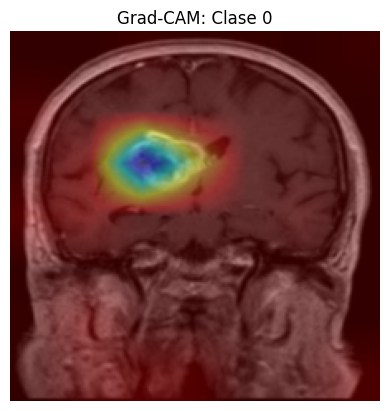

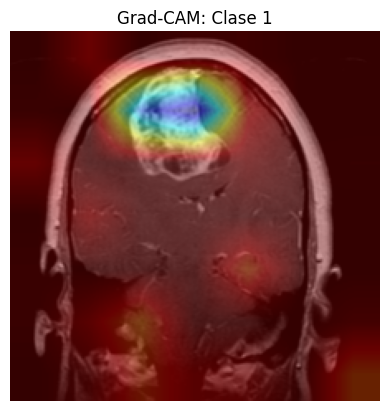

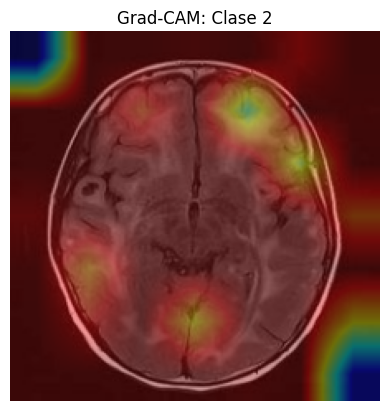

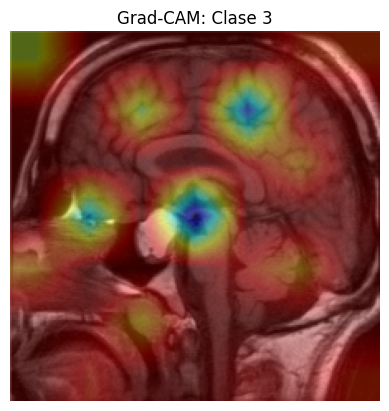

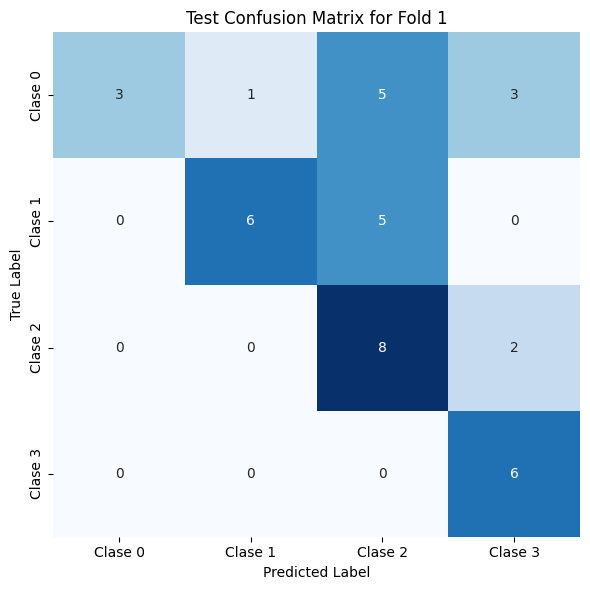

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [2], Epoch [1/10], Loss: 0.8313, Accuracy: 0.8035, Precision: 0.8100, Recall: 0.8126, F1 Score: 0.8106, MCC: 0.7304
Learning Rate: 0.001
Fold [2], Validation Loss: 1.2004, Validation Accuracy: 0.7931, Validation Precision: 0.7707, Validation Recall: 0.8139, Validation F1 Score: 0.7794, Validation MCC: 0.7234
Fold [2], Test Loss: 1.6637, Test Accuracy: 0.6154, Test Precision: 0.7886, Test Recall: 0.6591, Test F1 Score: 0.6216, Test MCC: 0.5474
Fold [2], Epoch [2/10], Loss: 0.5231, Accuracy: 0.8341, Precision: 0.8513, Recall: 0.8245, F1 Score: 0.8329, MCC: 0.7729
Learning Rate: 0.001
Fold [2], Validation Loss: 1.3166, Validation Accuracy: 0.7759, Validation Precision: 0.8379, Validation Recall: 0.7210, Validation F1 Score: 0.7430, Validation MCC: 0.6966
Fold [2], Test Loss: 2.9984, Test Accuracy: 0.6154, Test Precision: 0.7128, Test Recall: 0.6754, Test F1 Score: 0.5676, Test MCC: 0.5436
Fold [2], Epoch [3/10], Loss: 0.6142, Accuracy: 0.8079, Precision: 0.8309, Recall: 0.7843, F1 Sc

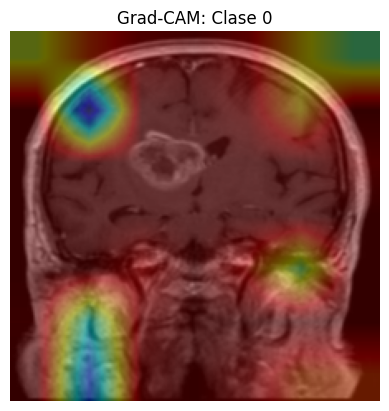

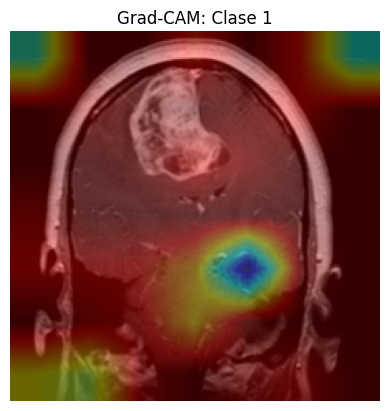

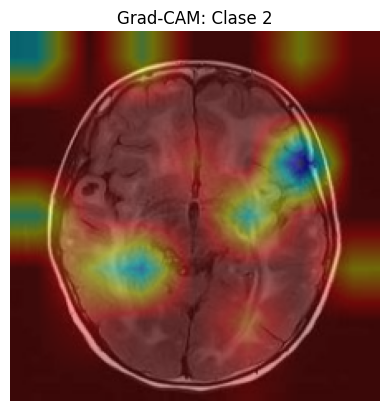

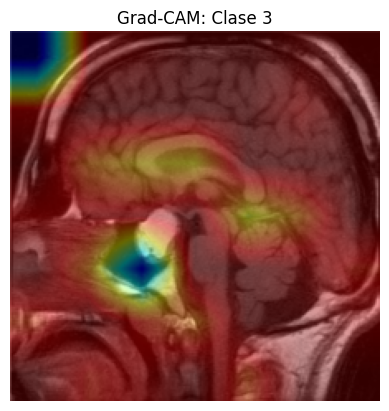

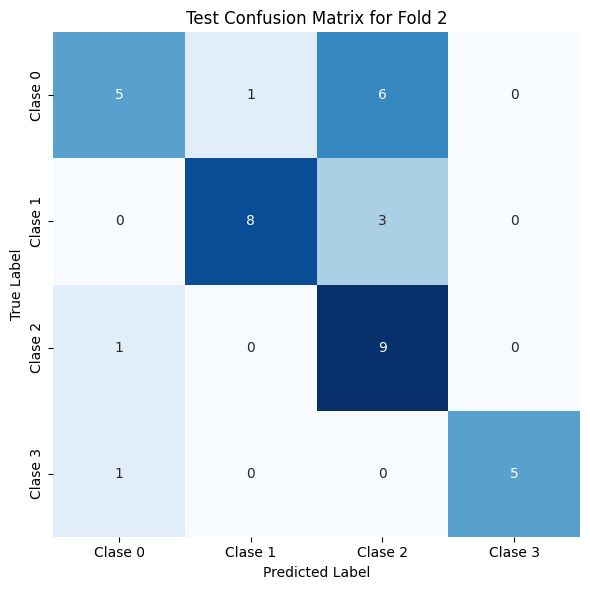

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [3], Epoch [1/10], Loss: 0.5676, Accuracy: 0.8522, Precision: 0.8587, Recall: 0.8336, F1 Score: 0.8440, MCC: 0.7959
Learning Rate: 0.001
Fold [3], Validation Loss: 0.1102, Validation Accuracy: 0.9474, Validation Precision: 0.9351, Validation Recall: 0.9539, Validation F1 Score: 0.9421, Validation MCC: 0.9283
Fold [3], Test Loss: 2.4805, Test Accuracy: 0.5897, Test Precision: 0.6073, Test Recall: 0.6295, Test F1 Score: 0.5646, Test MCC: 0.4827
Fold [3], Epoch [2/10], Loss: 0.4882, Accuracy: 0.8435, Precision: 0.8311, Recall: 0.8539, F1 Score: 0.8247, MCC: 0.7964
Learning Rate: 0.001
Fold [3], Validation Loss: 0.5173, Validation Accuracy: 0.8246, Validation Precision: 0.8190, Validation Recall: 0.7603, Validation F1 Score: 0.7724, Validation MCC: 0.7612
Fold [3], Test Loss: 2.0562, Test Accuracy: 0.5385, Test Precision: 0.5031, Test Recall: 0.5250, Test F1 Score: 0.4792, Test MCC: 0.4009
Fold [3], Epoch [3/10], Loss: 0.3014, Accuracy: 0.8957, Precision: 0.9102, Recall: 0.8694, F1 Sc

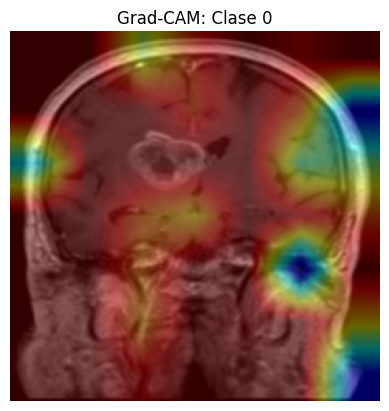

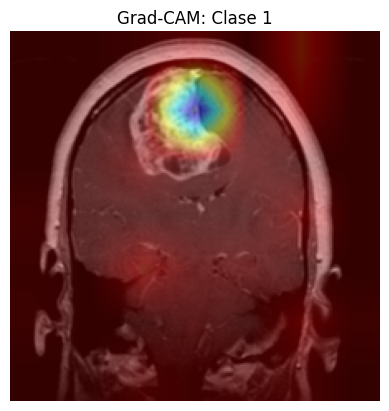

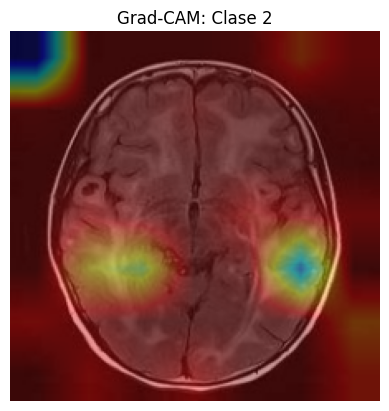

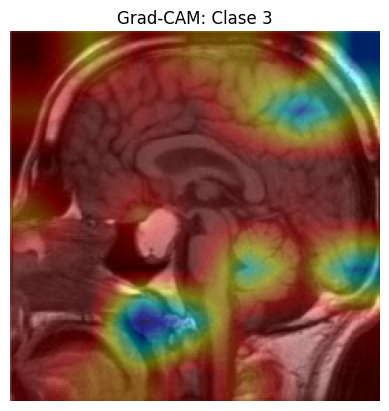

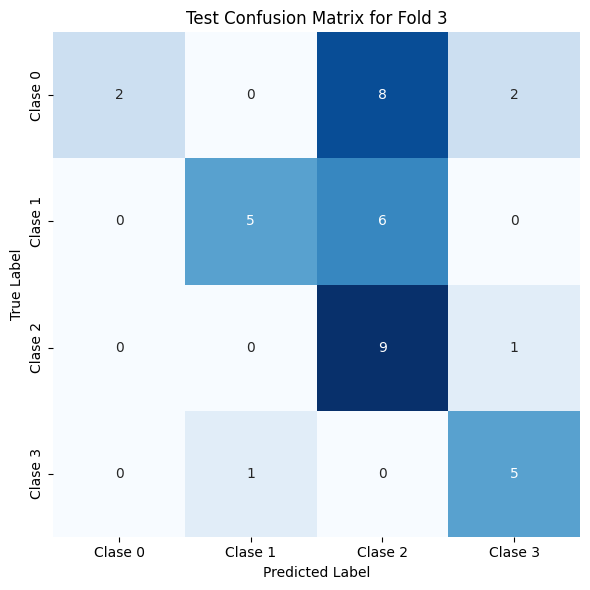

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [4], Epoch [1/10], Loss: 0.8048, Accuracy: 0.8696, Precision: 0.8764, Recall: 0.8667, F1 Score: 0.8697, MCC: 0.8208
Learning Rate: 0.001
Fold [4], Validation Loss: 0.5586, Validation Accuracy: 0.8772, Validation Precision: 0.9058, Validation Recall: 0.8959, Validation F1 Score: 0.8929, Validation MCC: 0.8393
Fold [4], Test Loss: 1.8162, Test Accuracy: 0.6667, Test Precision: 0.7321, Test Recall: 0.6985, Test F1 Score: 0.6648, Test MCC: 0.5771
Fold [4], Epoch [2/10], Loss: 0.4759, Accuracy: 0.8522, Precision: 0.8757, Recall: 0.8705, F1 Score: 0.8652, MCC: 0.8042
Learning Rate: 0.001
Fold [4], Validation Loss: 0.2844, Validation Accuracy: 0.8947, Validation Precision: 0.8957, Validation Recall: 0.9056, Validation F1 Score: 0.8953, Validation MCC: 0.8591
Fold [4], Test Loss: 1.6627, Test Accuracy: 0.5897, Test Precision: 0.6399, Test Recall: 0.6496, Test F1 Score: 0.5811, Test MCC: 0.5033
Fold [4], Epoch [3/10], Loss: 0.3379, Accuracy: 0.8652, Precision: 0.8532, Recall: 0.8359, F1 Sc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold [4], Test Loss: 1.4918, Test Accuracy: 0.5641, Test Precision: 0.5074, Test Recall: 0.5129, Test F1 Score: 0.4468, Test MCC: 0.4422
Fold [4], Epoch [4/10], Loss: 0.1861, Accuracy: 0.9348, Precision: 0.9321, Recall: 0.9306, F1 Score: 0.9312, MCC: 0.9101
Learning Rate: 0.001
Fold [4], Validation Loss: 0.2597, Validation Accuracy: 0.9123, Validation Precision: 0.9132, Validation Recall: 0.9270, Validation F1 Score: 0.9152, Validation MCC: 0.8840


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold [4], Test Loss: 3.8727, Test Accuracy: 0.4359, Test Precision: 0.5390, Test Recall: 0.4053, Test F1 Score: 0.3404, Test MCC: 0.3446
Fold [4], Epoch [5/10], Loss: 0.2879, Accuracy: 0.9435, Precision: 0.9452, Recall: 0.9500, F1 Score: 0.9474, MCC: 0.9222
Learning Rate: 0.001
Fold [4], Validation Loss: 0.2350, Validation Accuracy: 0.9474, Validation Precision: 0.9382, Validation Recall: 0.9556, Validation F1 Score: 0.9448, Validation MCC: 0.9292
Fold [4], Test Loss: 2.3429, Test Accuracy: 0.5128, Test Precision: 0.6364, Test Recall: 0.5091, Test F1 Score: 0.4711, Test MCC: 0.3903
Fold [4], Epoch [6/10], Loss: 0.2368, Accuracy: 0.9348, Precision: 0.9478, Recall: 0.9294, F1 Score: 0.9352, MCC: 0.9125
Learning Rate: 0.001
Fold [4], Validation Loss: 0.2944, Validation Accuracy: 0.9123, Validation Precision: 0.9331, Validation Recall: 0.9250, Validation F1 Score: 0.9262, Validation MCC: 0.8818
Fold [4], Test Loss: 1.3656, Test Accuracy: 0.6923, Test Precision: 0.7268, Test Recall: 0.7152,

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold [4], Test Loss: 3.3320, Test Accuracy: 0.5128, Test Precision: 0.4937, Test Recall: 0.4674, Test F1 Score: 0.4135, Test MCC: 0.3833
Fold [4], Epoch [9/10], Loss: 0.1288, Accuracy: 0.9435, Precision: 0.9562, Recall: 0.9452, F1 Score: 0.9496, MCC: 0.9230
Learning Rate: 0.001
Fold [4], Validation Loss: 0.4302, Validation Accuracy: 0.9123, Validation Precision: 0.9375, Validation Recall: 0.9281, Validation F1 Score: 0.9254, Validation MCC: 0.8871


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold [4], Test Loss: 3.0573, Test Accuracy: 0.4615, Test Precision: 0.4377, Test Recall: 0.4220, Test F1 Score: 0.3773, Test MCC: 0.3165
Fold [4], Epoch [10/10], Loss: 0.3177, Accuracy: 0.9652, Precision: 0.9733, Recall: 0.9572, F1 Score: 0.9642, MCC: 0.9525
Learning Rate: 0.001
Fold [4], Validation Loss: 0.1783, Validation Accuracy: 0.9123, Validation Precision: 0.9306, Validation Recall: 0.8861, Validation F1 Score: 0.8995, Validation MCC: 0.8821
Fold [4], Test Loss: 2.2275, Test Accuracy: 0.5897, Test Precision: 0.6715, Test Recall: 0.5902, Test F1 Score: 0.5762, Test MCC: 0.4730
Generando Grad-CAM por clase para el Fold 4...


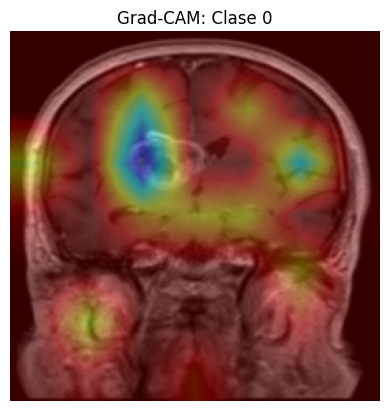

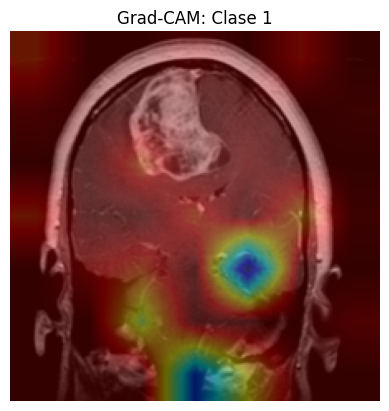

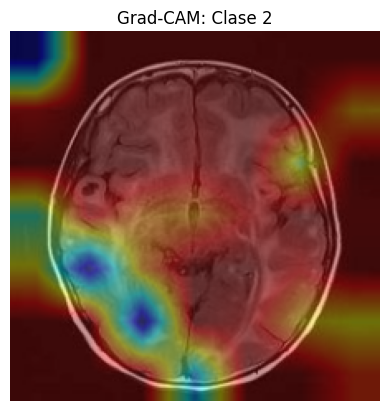

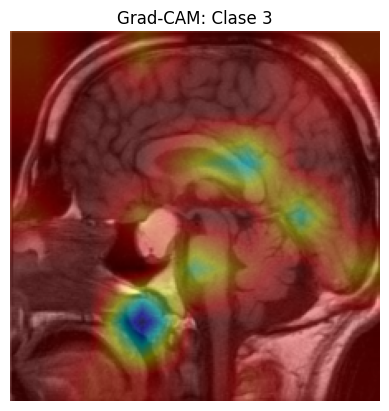

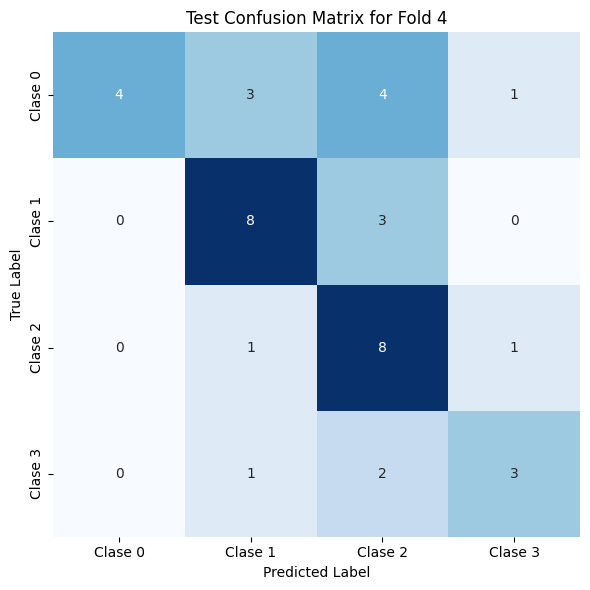

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold [5], Epoch [1/10], Loss: 0.4935, Accuracy: 0.9217, Precision: 0.9312, Recall: 0.9244, F1 Score: 0.9263, MCC: 0.8931
Learning Rate: 0.001
Fold [5], Validation Loss: 0.1460, Validation Accuracy: 0.9298, Validation Precision: 0.9458, Validation Recall: 0.8980, Validation F1 Score: 0.9143, Validation MCC: 0.9054
Fold [5], Test Loss: 2.3908, Test Accuracy: 0.5897, Test Precision: 0.6843, Test Recall: 0.6549, Test F1 Score: 0.5442, Test MCC: 0.5055
Fold [5], Epoch [2/10], Loss: 0.7293, Accuracy: 0.8435, Precision: 0.8483, Recall: 0.8507, F1 Score: 0.8357, MCC: 0.7974
Learning Rate: 0.001
Fold [5], Validation Loss: 0.8109, Validation Accuracy: 0.8947, Validation Precision: 0.9083, Validation Recall: 0.8865, Validation F1 Score: 0.8958, Validation MCC: 0.8550
Fold [5], Test Loss: 1.5348, Test Accuracy: 0.5641, Test Precision: 0.6554, Test Recall: 0.5693, Test F1 Score: 0.5433, Test MCC: 0.4527
Fold [5], Epoch [3/10], Loss: 0.4318, Accuracy: 0.8652, Precision: 0.8706, Recall: 0.8627, F1 Sc

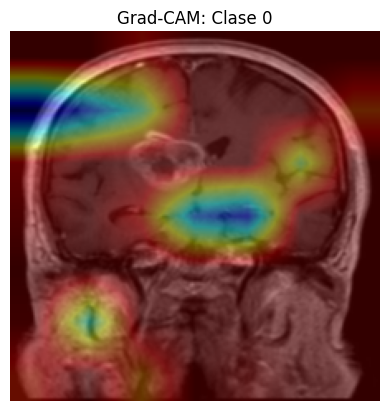

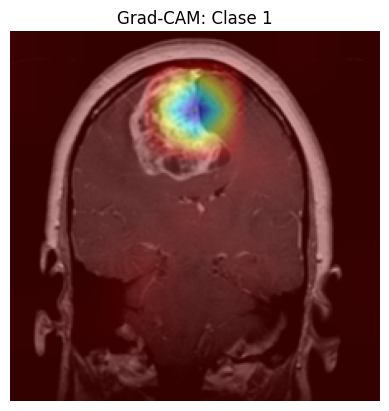

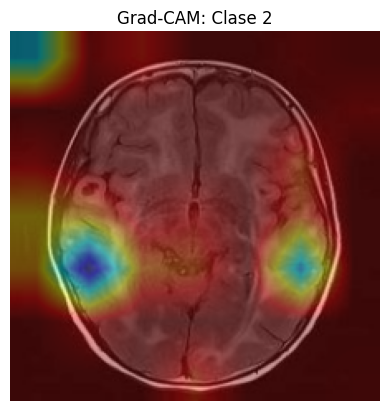

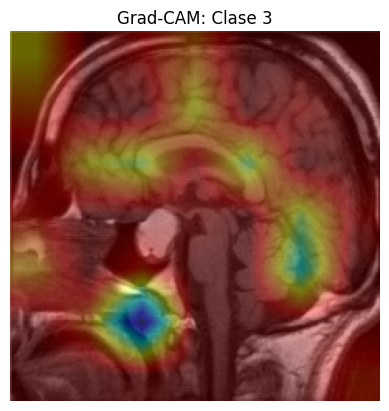

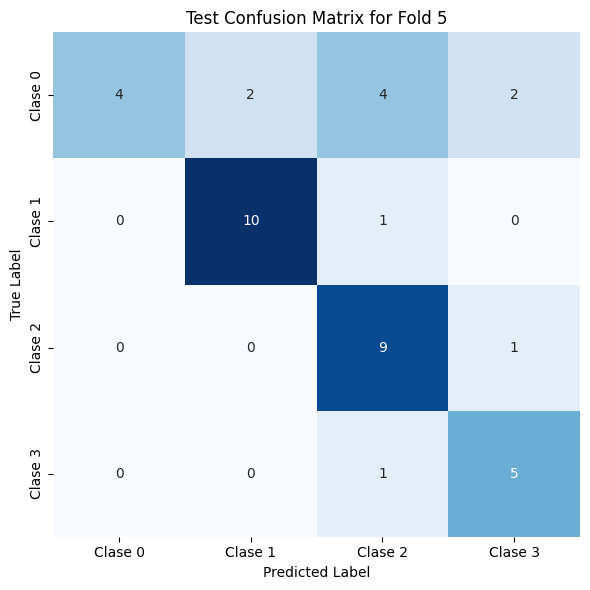

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener etiquetas del subset (asumiendo que train_subset[i] devuelve (imagen, etiqueta))
train_targets = [train_subset[i][1] for i in range(len(train_subset))]

# Definir el número de pliegues
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Ciclo de Stratified K-Fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_subset, train_targets)):
    wandb.init(project="SARTAJ Dataset training", name=f"Fold_{fold + 1}")

    # Configurar los datos de entrenamiento y validación para este pliegue
    train_fold_subset = torch.utils.data.Subset(train_subset, train_idx)
    val_fold_subset = torch.utils.data.Subset(train_subset, val_idx)

    # Crear los DataLoaders
    train_loader = DataLoader(train_fold_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_fold_subset, batch_size=32, shuffle=False)

    # Reiniciar el modelo y optimizador para cada pliegue
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=False)

    num_epochs = 10
    train_confusion_matrices = []
    test_confusion_matrices = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_outputs = []
        all_probs = []

        for images, labels in train_loader:
            labels = labels.long()
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            pred = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            all_outputs.extend(pred)
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            all_probs.extend(probs)

        train_accuracy = accuracy_score(all_labels, all_outputs)
        train_precision = precision_score(all_labels, all_outputs, average='macro')
        train_recall = recall_score(all_labels, all_outputs, average='macro')
        train_f1 = f1_score(all_labels, all_outputs, average='macro')
        train_cm = confusion_matrix(all_labels, all_outputs)
        train_confusion_matrices.append(train_cm)
        train_mcc = matthews_corrcoef(all_labels, all_outputs)

        wandb.log({
            "Fold": fold + 1,
            "Epoch": epoch + 1,
            "Loss": running_loss / len(train_loader),
            "Accuracy": train_accuracy,
            "Precision": train_precision,
            "Recall": train_recall,
            "F1 Score": train_f1,
            "MCC": train_mcc,
            "Learning Rate": optimizer.param_groups[0]['lr'],
        })
         # Mostrar resultados de entrenamiento
        print(f"Fold [{fold + 1}], Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, "
              f"Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, "
              f"Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}, MCC: {train_mcc:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")


        # === Validación ===
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            all_val_labels = []
            all_val_outputs = []
            all_val_probs = []

            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                all_val_labels.extend(labels.cpu().numpy())
                val_pred = torch.argmax(outputs, dim=1).detach().cpu().numpy()
                all_val_outputs.extend(val_pred)
                val_probs = torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()
                all_val_probs.extend(val_probs)

            val_accuracy = accuracy_score(all_val_labels, all_val_outputs)
            val_precision = precision_score(all_val_labels, all_val_outputs, average='macro')
            val_recall = recall_score(all_val_labels, all_val_outputs, average='macro')
            val_f1 = f1_score(all_val_labels, all_val_outputs, average='macro')
            val_mcc = matthews_corrcoef(all_val_labels, all_val_outputs)

            wandb.log({
                "Fold": fold + 1,
                "Validation Loss": val_loss / len(val_loader),
                "Validation Accuracy": val_accuracy,
                "Validation Precision": val_precision,
                "Validation Recall": val_recall,
                "Validation F1 Score": val_f1,
                "Validation MCC": val_mcc,
            })
            # Mostrar resultados de validación
            print(f"Fold [{fold + 1}], Validation Loss: {val_loss / len(val_loader):.4f}, "
                  f"Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, "
                  f"Validation Recall: {val_recall:.4f}, Validation F1 Score: {val_f1:.4f}, "
                  f"Validation MCC: {val_mcc:.4f}")  # Mostrar MCC de la validación)

        scheduler.step(val_loss)

        # === Test ===
        model.eval()
        with torch.no_grad():
            all_test_labels = []
            all_test_outputs = []
            all_test_probs = []
            test_loss = 0.0

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                all_test_labels.extend(labels.cpu().numpy())
                test_pred = torch.argmax(outputs, dim=1).detach().cpu().numpy()
                all_test_outputs.extend(test_pred)
                test_probs = torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()
                all_test_probs.extend(test_probs)

            test_accuracy = accuracy_score(all_test_labels, all_test_outputs)
            test_precision = precision_score(all_test_labels, all_test_outputs, average='macro')
            test_recall = recall_score(all_test_labels, all_test_outputs, average='macro')
            test_f1 = f1_score(all_test_labels, all_test_outputs, average='macro')
            test_mcc = matthews_corrcoef(all_test_labels, all_test_outputs)
            test_cm = confusion_matrix(all_test_labels, all_test_outputs)
            test_confusion_matrices.append(test_cm)

            wandb.log({
                "Fold": fold + 1,
                "Test Loss": test_loss / len(test_loader),
                "Test Accuracy": test_accuracy,
                "Test Precision": test_precision,
                "Test Recall": test_recall,
                "Test F1 Score": test_f1,
                "Test MCC": test_mcc,
            })
             # Mostrar resultados de prueba
            print(f"Fold [{fold + 1}], Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}, "
                  f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, "
                  f"Test F1 Score: {test_f1:.4f}, Test MCC: {test_mcc:.4f}")  # Mostrar MCC")

    # === Grad-CAM por clase ===
    print(f"Generando Grad-CAM por clase para el Fold {fold + 1}...")
    class_names = ['Clase 0', 'Clase 1', 'Clase 2', 'Clase 3']
    images_per_class = {}

    # Buscar una imagen por clase en el test set
    for images, labels in test_loader:
        for img, lbl in zip(images, labels):
            cls = lbl.item()
            if cls not in images_per_class:
                images_per_class[cls] = img.unsqueeze(0).to(device)
            if len(images_per_class) == len(class_names):
                break
        if len(images_per_class) == len(class_names):
            break

    # Generar Grad-CAM para cada clase
    for cls_idx in range(len(class_names)):
      if cls_idx in images_per_class:
        input_image = images_per_class[cls_idx]
        activations = register_hooks(model)
        grad_cam_map = generate_grad_cam(model, input_image, cls_idx, activations, device)
        show_grad_cam(grad_cam_map, input_image.cpu(), class_names[cls_idx])


    # Matriz de confusión final del fold
    plt.figure(figsize=(6, 6))
    sns.heatmap(test_confusion_matrices[-1], annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Test Confusion Matrix for Fold {fold + 1}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    wandb.log({"Test Confusion Matrix": wandb.Image(plt)})
    plt.show()

    wandb.finish()
